In [7]:
#Here we import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import EfficientNetB1, MobileNet,MobileNetV2,NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import pandas as pd
import scipy
from matplotlib import pyplot 
from sklearn.model_selection import train_test_split # to split our train data into train and validation sets
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
np.random.seed(13)
import os

In [2]:
#here we define a function which creates a model using base models (the transfer models)
def create_model(base_model, model_name):
   model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])
   print(model_name + " Network Architecture:")
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   #plot_model(model, to_file= model_name + '.png', show_shapes=True, show_layer_names=True)
   return model

**Base models**

In [3]:
# Here we define the transfer models (base models) and set the necessary parameters

InputShape = (224,224,3) # the shape of the images 
# Include_top lets you select if you want the final dense layers or not.
NasNetBase = NASNetMobile(include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=InputShape,
    pooling=None,
    classes=2)
# Freezing(i.e setting trainable=False) will prevent the weights in our base model from being updated during training.
NasNetBase.trainable = True


MobileNetV2Base = MobileNetV2(include_top=False,
    weights="imagenet",
    alpha=1.0,
    input_tensor=None,
    input_shape=InputShape,
    pooling=None,
    classes=2,
    classifier_activation="softmax")
MobileNetV2Base.trainable = True


MobileNetBase = MobileNet(include_top=False,
    weights="imagenet",
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    input_tensor=None,
    input_shape=InputShape,
    pooling=None,
    classes=2,
    classifier_activation="softmax")
MobileNetBase.trainable = True


EfficientNetBase = EfficientNetB1(include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=InputShape,
    pooling=None,
    classes=2,
    classifier_activation="softmax")
EfficientNetBase.trainable = True

27025408/27018416 [==============================] - 8s 0us/step


**THE MAIN MODELS**

In [4]:
#Here the models are created using the pre-defined function
EfficientNet = create_model(EfficientNetBase, 'EfficientNet')
NasNet = create_model(NasNetBase,'NasNetModel')
MobileNet = create_model(MobileNetBase, 'MobileNet')
MobileNetV2 = create_model(MobileNetV2Base, 'MobileNetV2')

Models = [NasNet,MobileNet,MobileNetV2,EfficientNet]

EfficientNet Network Architecture:
NasNetModel Network Architecture:
MobileNet Network Architecture:
MobileNetV2 Network Architecture:


In [8]:
#Changed to working directory to the location of the dataset and loaded the dataset description for local host.
os.chdir("..\kaggle_3m")
brain_df = pd.read_csv('data_frame.csv')

#For google colab
#brain_df = pd.read_csv('/content/drive/MyDrive/kaggle_3m/Gdrive.csv')
# Here we decided to drop unncessary coloums from the dataset
brain_df_train = brain_df.drop(columns=['Unnamed: 0', 'patient'], axis=1)
brain_df_train['diagnosis'] = brain_df['diagnosis'].apply(lambda x: str(x)) #changes the type of the values of the column to sting
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   diagnosis   3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [9]:
train, test = train_test_split(brain_df_train, test_size=0.15) #splits the data into training and testing sets
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='diagnosis',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(224,224)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='diagnosis',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(224,224)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='diagnosis',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(224,224)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [10]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="esemble-weights_{epoch:02d}-{val_loss:.2f}.hdf5",
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [11]:
TrainedModel = []
for model in Models:
  model.fit(train_generator,steps_per_epoch= train_generator.n // train_generator.batch_size,epochs = 10,validation_data= valid_generator,validation_steps= valid_generator.n // valid_generator.batch_size,callbacks=[checkpointer, earlystopping])
  TrainedModel.append(model)



Epoch 1/10
187/187 [==============================] - 681s 3s/step - loss: 0.3191 - accuracy: 0.8712 - val_loss: 1.2809 - val_accuracy: 0.8562

Epoch 00001: val_loss improved from inf to 1.28086, saving model to esemble-weights.hdf5


c:\users\hi\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
187/187 [==============================] - 643s 3s/step - loss: 0.1486 - accuracy: 0.9478 - val_loss: 1.5245 - val_accuracy: 0.8781

Epoch 00002: val_loss did not improve from 1.28086
Epoch 3/10
187/187 [==============================] - 600s 3s/step - loss: 0.1026 - accuracy: 0.9666 - val_loss: 1.2642 - val_accuracy: 0.9062

Epoch 00003: val_loss improved from 1.28086 to 1.26420, saving model to esemble-weights.hdf5
Epoch 4/10
187/187 [==============================] - 614s 3s/step - loss: 0.0887 - accuracy: 0.9702 - val_loss: 2.2395 - val_accuracy: 0.8719

Epoch 00004: val_loss did not improve from 1.26420
Epoch 5/10
187/187 [==============================] - 682s 4s/step - loss: 0.0657 - accuracy: 0.9789 - val_loss: 6.3449 - val_accuracy: 0.8031

Epoch 00005: val_loss did not improve from 1.26420
Epoch 6/10
187/187 [==============================] - 673s 4s/step - loss: 0.0566 - accuracy: 0.9803 - val_loss: 2.2716 - val_accuracy: 0.8844

Epoch 00006: val_loss did not impr

In [22]:
#Save the models
#if not os.path.exists('my_models'):
#    os.makedirs('my_models')
#for i in range(len(TrainedModel)):
#    TrainedModel[i].save('my_models/'+str(TrainedModel[i])+str(i+1))    
# Predict labels with models

labels = []
for m in TrainedModel:
    predicts = np.argmax(m.predict(test_generator), axis=1)
    labels.append(predicts)

# Ensemble with voting
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))
print(labels)


[[1 0 0 0]
 [0 0 0 0]
 [1 1 1 0]
 ...
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]]


In [46]:
labls = scipy.stats.mode(labels,axis=1)[0]
labls = np.squeeze(labls)


original = np.asarray(test['diagnosis']).astype('int')   

In [47]:
print(labls)

[0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1
 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0
 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1
 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0
 0 1 1 0 1 1 1 0 0 1 0 0 

In [51]:
# Dump predictions into submission file
pd.DataFrame({'ImageId' : np.arange(1, labels.shape[0] + 1), 'Label' : labls }).to_csv('submission.csv', index=False)

0.9271186440677966
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       380
           1       0.98      0.81      0.89       210

    accuracy                           0.93       590
   macro avg       0.94      0.90      0.92       590
weighted avg       0.93      0.93      0.93       590



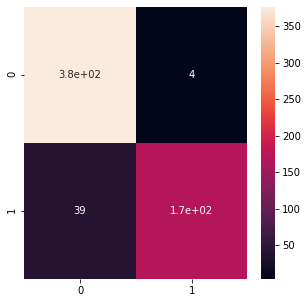

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
pred = labls
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
pyplot.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

**Saving The Trained Models**

In [55]:
TrainedModel[0].save('my_firstModel')

c:\users\hi\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: my_firstModel\assets


INFO:tensorflow:Assets written to: my_firstModel\assets


In [56]:
TrainedModel[1].save('my_secondModel')
TrainedModel[2].save('my_thirdModel')
TrainedModel[3].save('my_forthModel')

INFO:tensorflow:Assets written to: my_secondModel\assets


INFO:tensorflow:Assets written to: my_secondModel\assets
c:\users\hi\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: my_thirdModel\assets


INFO:tensorflow:Assets written to: my_thirdModel\assets
c:\users\hi\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: my_forthModel\assets


INFO:tensorflow:Assets written to: my_forthModel\assets
